In [1]:
import re

import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

## Data Cleaning and Exploration

In [3]:
sample = comments.Reply.iloc[10]
sample

'Sorry, I am new to the site, can I ask a question?\n\nDo we get to keep the game after May 21?'

In [4]:
re.sub(r'\(?http\S+', '', sample)

'Sorry, I am new to the site, can I ask a question?\n\nDo we get to keep the game after May 21?'

Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [5]:
sample = comments.Reply.iloc[9]
sample

'Thats so damn right xD'

In [6]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['Thats', 'so', 'damn', 'right', 'xD']

In [7]:
' '.join(word_tokenized)

'Thats so damn right xD'

#### Bigrams

In [8]:
sample = ['Epic', 'Games', 'Store', 'is', 'an', 'Epic', 'Games', 'store']

In [9]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# Find bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# Return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('Epic', 'Games')]


Let's try it on first 10000 rows of our text

In [10]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [11]:
all_text = nltk.word_tokenize(all_text)

In [12]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('OTHERS', 'CLICKED'), ('Starter', 'Pack'), ('Theft', 'Auto'), ('Rocket', 'League'), ('Grand', 'Theft'), ('Criminal', 'Enterprise'), ('task', 'manager'), ('CLICKED', 'THIS'), ('shopping', 'cart'), ('Watch', 'Dogs')]


#### Wordcloud

In [13]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [14]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

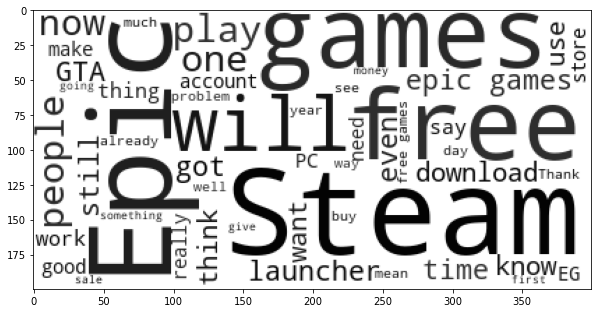

In [15]:
stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# Generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

In [16]:
# Uncomment to use a subset of the rows.
df = comments #[comments.Key<101]
df.shape

(34367, 4)

In [17]:
# The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

## Sentiment Analysis

- ### __Sentiment Classification using Vader package__

In [18]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

# Initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

We can add sentiment scores to words manually if we want

In [20]:
new_words = {
    'Steam' : 0,
    'Epic Games' : 0,
}

sid.lexicon.update(new_words)

In [21]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

In [22]:
df[['vdr neg','vdr neu','vdr pos','vdr compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [23]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0


In [24]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound
count,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000
mean,2.657928,335.480286,0.065198,0.790132,0.141033,0.161202
std,6.106541,272.709551,0.119265,0.214190,0.190331,0.446996
min,-47.000000,0.000000,0.000000,0.000000,0.000000,-0.994700
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000
50%,1.000000,261.000000,0.000000,0.828000,0.084000,0.000000
75%,3.000000,526.000000,0.095000,1.000000,0.206000,0.510600
max,212.000000,995.000000,1.000000,1.000000,1.000000,0.999100


- ### Sentiment Classification using Textblob package

In [25]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [26]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [27]:
df[['TB Classification','TB pos','TB neg']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [28]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.0,1.0,0.0,0.0,neg,0.279181,0.720819
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.0,1.0,0.0,0.0,pos,0.667773,0.332227
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.0,1.0,0.0,0.0,pos,0.935340,0.064660


In [29]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB pos,TB neg
count,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,34367.000000,3.436700e+04,3.436700e+04
mean,2.657928,335.480286,0.065198,0.790132,0.141033,0.161202,5.686343e-01,4.313657e-01
std,6.106541,272.709551,0.119265,0.214190,0.190331,0.446996,2.682720e-01,2.682720e-01
min,-47.000000,0.000000,0.000000,0.000000,0.000000,-0.994700,1.682455e-07,8.749978e-27
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000,3.876036e-01,2.163452e-01
50%,1.000000,261.000000,0.000000,0.828000,0.084000,0.000000,5.560954e-01,4.439046e-01
75%,3.000000,526.000000,0.095000,1.000000,0.206000,0.510600,7.836548e-01,6.123964e-01
max,212.000000,995.000000,1.000000,1.000000,1.000000,0.999100,1.000000e+00,9.999998e-01


In [30]:
df['TB Classification'].value_counts()

pos    21256
neg    13111
Name: TB Classification, dtype: int64

- ### Sentiment Classification using Self-Trained Classifier Module for Kaggle

In [31]:
import import_ipynb
%run Kaggle_Trained_Classifier.ipynb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
Z = vectorizer.transform(df['Reply'])

In [33]:
predicted2 = nb.predict(Z)

In [34]:
df2 = df

In [35]:
df2['Classification for Kaggle'] = predicted2

In [36]:
df2.head()

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg,Classification for Kaggle
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.000,1.000,0.000,0.0000,neg,0.279181,0.720819,neutral
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.000,1.000,0.000,0.0000,pos,0.667773,0.332227,neutral
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.000,1.000,0.000,0.0000,pos,0.935340,0.064660,neutral
3,Downloading it even if my computer doesnt supp...,9.0,2020-05-15 05:29:58,0.0,0.220,0.780,0.000,-0.3089,pos,0.659854,0.340146,neutral
4,"Man the site crashing , changing language auto...",28.0,2020-05-15 03:34:30,0.0,0.109,0.723,0.168,0.4211,pos,0.928223,0.071777,neutral


In [37]:
predicted2.shape

(34367,)

In [38]:
df.shape

(34367, 12)

In [39]:
df['Classification for Kaggle'].value_counts()

neutral     19140
negative     8166
positive     7061
Name: Classification for Kaggle, dtype: int64

In [40]:
df2.head(10)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg,Classification for Kaggle
0,My game launcher turned Russian,59.0,2020-05-15 03:24:53,0.0,0.000,1.000,0.000,0.0000,neg,0.279181,0.720819,neutral
1,Every time I refresh my epic game launcher it ...,21.0,2020-05-15 03:44:36,0.0,0.000,1.000,0.000,0.0000,pos,0.667773,0.332227,neutral
2,Premium edition actually,9.0,2020-05-15 03:55:30,0.0,0.000,1.000,0.000,0.0000,pos,0.935340,0.064660,neutral
3,Downloading it even if my computer doesnt supp...,9.0,2020-05-15 05:29:58,0.0,0.220,0.780,0.000,-0.3089,pos,0.659854,0.340146,neutral
4,"Man the site crashing , changing language auto...",28.0,2020-05-15 03:34:30,0.0,0.109,0.723,0.168,0.4211,pos,0.928223,0.071777,neutral
5,xD i got so hyped,3.0,2020-05-15 03:28:37,0.0,0.000,0.441,0.559,0.5859,neg,0.319025,0.680975,positive
6,My game launcher also turned Russian all of a ...,3.0,2020-05-15 03:31:21,0.0,0.000,1.000,0.000,0.0000,neg,0.295564,0.704436,negative
7,What 's next week free game ? ! 😅,3.0,2020-05-15 03:40:26,0.0,0.000,0.582,0.418,0.5562,pos,0.561565,0.438435,neutral
8,Lol my changed language,3.0,2020-05-15 03:46:54,0.0,0.000,0.517,0.483,0.4215,neg,0.208978,0.791022,neutral
9,Thats so damn right xD,2.0,2020-05-15 03:48:45,0.0,0.298,0.298,0.404,0.2665,neg,0.499957,0.500043,positive


Using the Textblob package, we can see that the Epic Games Store reddit has a mixed sentiment response on posts. 39% bad sentimes and 61% good sentiment.

Using our own trained classification module, there seems to be more Negative sentiments compared to Positive ones. 23% Negative response and 21% Positive sentimes. But if we set aside the Neutral Sentimes, this looks like a very mixed sentiment.

In [41]:
df['Classification for Kaggle'].value_counts(normalize=True) * 100

neutral     55.692961
negative    23.761166
positive    20.545872
Name: Classification for Kaggle, dtype: float64

In [42]:
df['TB Classification'].value_counts(normalize=True) * 100

pos    61.850031
neg    38.149969
Name: TB Classification, dtype: float64

In [43]:
#Importing matplotlib which is a plotting library
import matplotlib.pyplot as plt

Text(0, 0.5, 'compound score')

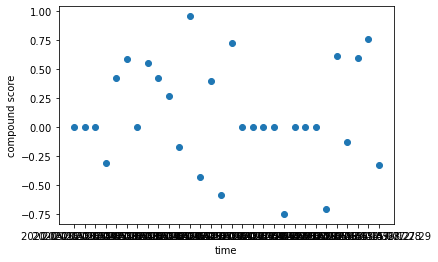

In [44]:
#Make a plot to compare the time with the compound score
plt.scatter(df['Time'].head(30),df['vdr compound'].head(30))
plt.xlabel('time')
plt.ylabel('compound score')

In [45]:
overTime = df.drop(["Reply","Upvote","Key","vdr neg","vdr neu","vdr pos","TB Classification","TB pos","TB neg","Classification for Kaggle"], axis =1)

In [46]:
overTime.head(30)

,Time,vdr compound
0,2020-05-15 03:24:53,0.0000
1,2020-05-15 03:44:36,0.0000
2,2020-05-15 03:55:30,0.0000
3,2020-05-15 05:29:58,-0.3089
4,2020-05-15 03:34:30,0.4211
5,2020-05-15 03:28:37,0.5859
6,2020-05-15 03:31:21,0.0000
7,2020-05-15 03:40:26,0.5562
8,2020-05-15 03:46:54,0.4215
9,2020-05-15 03:48:45,0.2665


In [80]:
overTime2 = overTime.head(100)

In [66]:
#Graph the relationship between attributes
import seaborn as sns

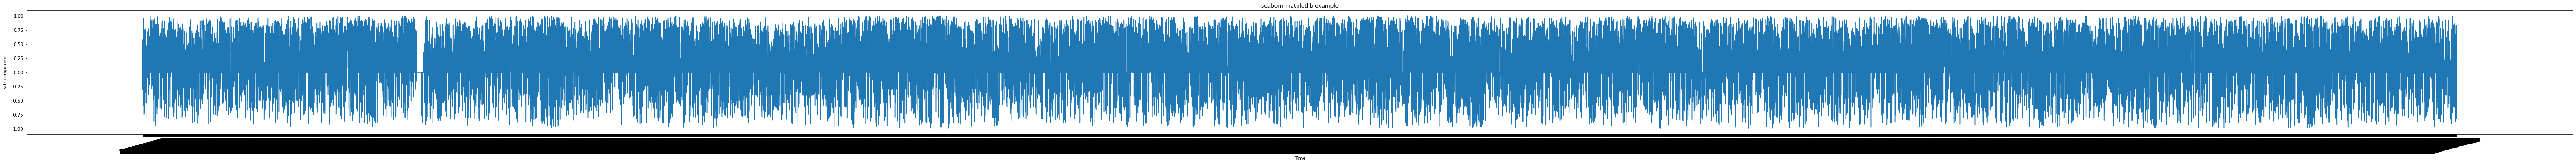

In [68]:
fig, ax = plt.subplots(figsize=(100,5))
sns.lineplot(x="Time", y="vdr compound", data=overTime)
plt.xticks(rotation=15)
plt.title('seaborn-matplotlib example')
plt.show()

In [83]:
#overTime2['Datetime'] = pd.to_datetime(overTime2['date'] + ' ' + df['time'])
#df = df.set_index('Datetime')

overTime2 = overTime2.set_index(pd.DatetimeIndex(overTime2['Time']))



In [84]:
overTime2.head()
overTime2.groupby(pd.Grouper(freq="M")) 

In [85]:
overTime2.head()

,Time,vdr compound
Time,,
2020-05-15 03:24:53,2020-05-15 03:24:53,0.0000
2020-05-15 03:44:36,2020-05-15 03:44:36,0.0000
2020-05-15 03:55:30,2020-05-15 03:55:30,0.0000
2020-05-15 05:29:58,2020-05-15 05:29:58,-0.3089
2020-05-15 03:34:30,2020-05-15 03:34:30,0.4211


In [86]:
g = overTime2.groupby(pd.Grouper(freq="M"))  # DataFrameGroupBy (grouped by Month)

g.sum()

,vdr compound
Time,
2020-05-31,13.7420
2020-06-30,0.7783


In [88]:
over_time = overTime.set_index(pd.DatetimeIndex(overTime['Time']))

In [89]:
over_time.head()

,Time,vdr compound
Time,,
2020-05-15 03:24:53,2020-05-15 03:24:53,0.0000
2020-05-15 03:44:36,2020-05-15 03:44:36,0.0000
2020-05-15 03:55:30,2020-05-15 03:55:30,0.0000
2020-05-15 05:29:58,2020-05-15 05:29:58,-0.3089
2020-05-15 03:34:30,2020-05-15 03:34:30,0.4211


In [90]:
g = over_time.groupby(pd.Grouper(freq="M")) 

In [96]:
data_sum = g.sum()

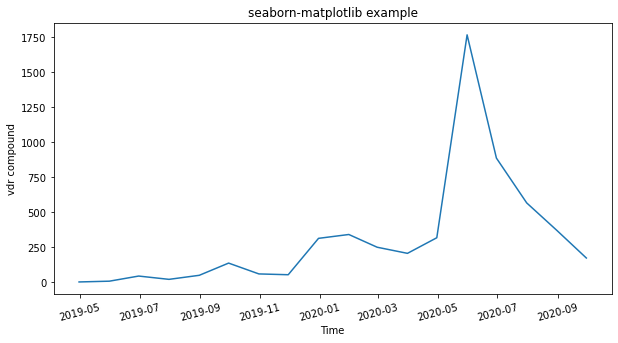

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_sum.index, y="vdr compound", data=data_sum)
plt.xticks(rotation=15)
plt.title('seaborn-matplotlib example')
plt.show()